In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/resources/resources/BBC News Train.csv
/kaggle/input/resources/resources/BBC News Sample Solution.csv
/kaggle/input/resources/resources/BBC News Test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import certifi
import ssl
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [3]:
file_path ='/kaggle/input/resources/resources/BBC News Sample Solution.csv'
train_path = '/kaggle/input/resources/resources/BBC News Train.csv'
test_path = '/kaggle/input/resources/resources/BBC News Test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sample_solution = pd.read_csv(file_path)

# 1.Exploratory Data Analysis (EDA)

## 1.1 Basic Data Inspection

In [4]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


## 1.2. Inspect null values

In [6]:
df_train.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [7]:
df_train["Text"][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

From intial data Inspection , training data contains 1490 records with 3 columns - 'ArticleId', 'Text', 'Category' and test data contains 735 records with 2 columns- 'ArticleId', 'Text'. 'Text' field is english free text.'Category' field has 5 unique values ['business', 'tech', 'politics', 'sport', 'entertainment'], no null/nan value.Each category has a good representation in entire training dataset considering its count

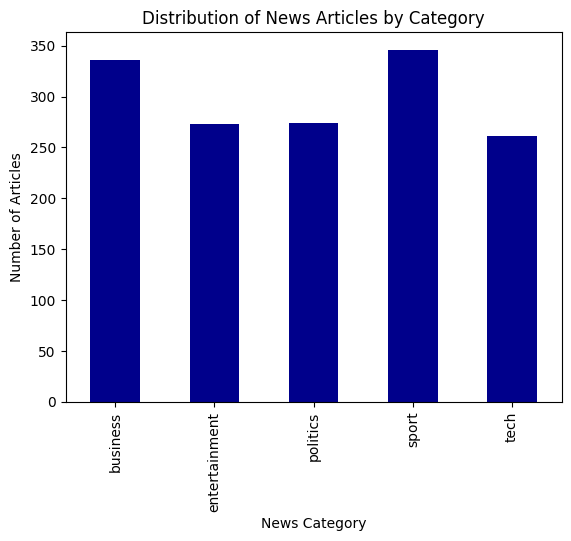

In [8]:
# Group by category and count the number of texts
train_cat = df_train.groupby('Category').count()

# Plot using a specific color (e.g., skyblue)
train_cat['Text'].plot(kind='bar', color='darkblue')

# Add labels and title
plt.xlabel('News Category')
plt.ylabel('Number of Articles')
plt.title('Distribution of News Articles by Category')

# Show the plot
plt.show()


From intial data Inspection , training data contains 1490 records with 3 columns - 'ArticleId', 'Text', 'Category' and test data contains 735 records with 2 columns- 'ArticleId', 'Text'. 'Text' field is english free text.'Category' field has 5 unique values ['business', 'tech', 'politics', 'sport', 'entertainment'], no null/nan value.Each category has a good representation in entire training dataset considering its count.

The data is already in a clean, rectangular format, so the primary preprocessing step involves using TF-IDF to assign weights to each word. These weights will be organized into a matrix, which can then be factored to predict the categories.

### 1.3 Data Preprocessing

Text pre-processing plays a critical role in preparing the data. This step involves stemming, which reduces words to their root forms, and removing stop words—common terms like "the" that carry little meaningful information.

I will use TF-IDF to clean and extract the texts as features

TF-IDF stands for Term Frequency–Inverse Document Frequency. It produces a matrix that emphasizes the importance of words based on how often they appear in individual documents relative to their rarity across the entire corpus. While the resulting matrix is initially skewed, it can be normalized into a format that’s easier to factor—something that scikit-learn conveniently handles for us.

In TF-IDF, each word is assigned a weight that reflects both how frequently it appears and how rare it is. The underlying idea is that globally rare words serve as better categorical signals—especially when they occur frequently within a document. These "buzzwords" become strong indicators of the document’s category.

Here’s how it works mathematically:

    Term Frequency (TF): Measures how often a word appears in a document. (In our case, we’ll consider individual words rather than phrases, due to processing constraints.)

    Inverse Document Frequency (IDF): Measures how rare a word is across all documents.

Multiplying TF and IDF gives a weight that reflects a word’s usefulness in distinguishing categories. Running this over the entire dataset (train or test) produces a matrix of shape (number of documents × number of unique terms).

Citation :https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424

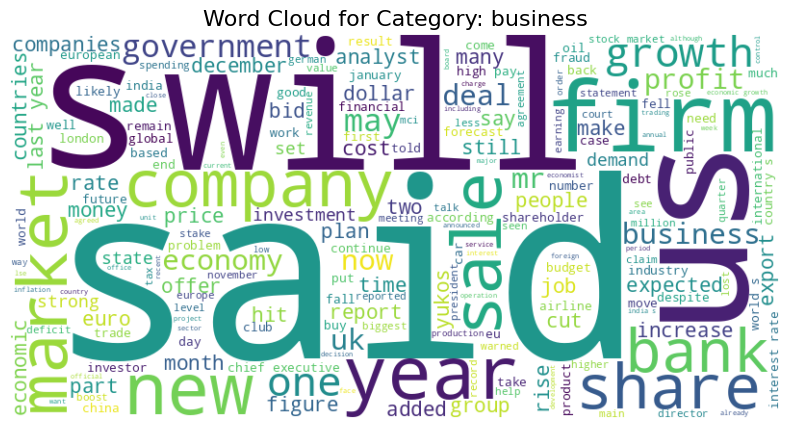

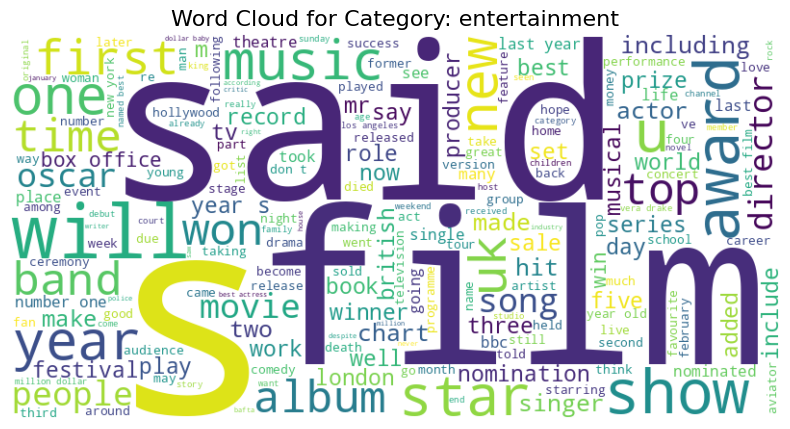

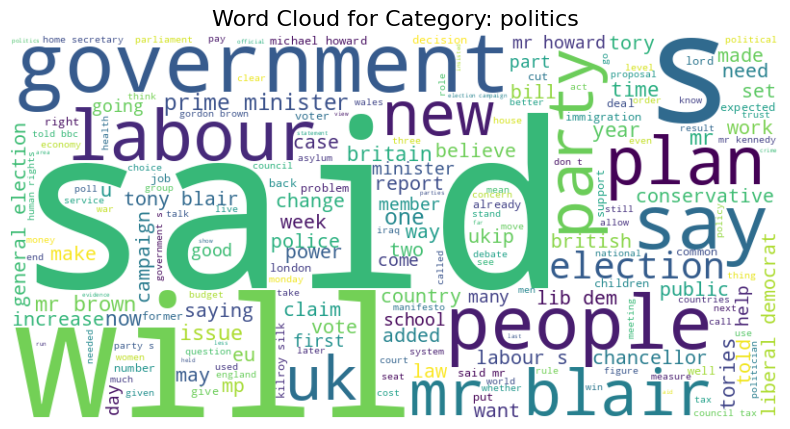

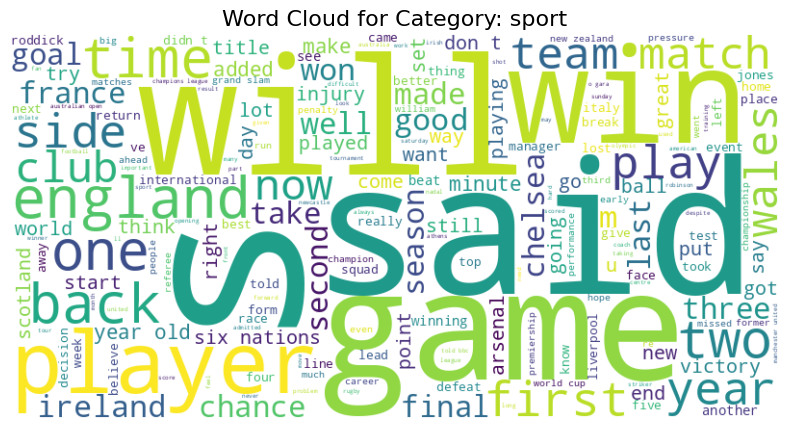

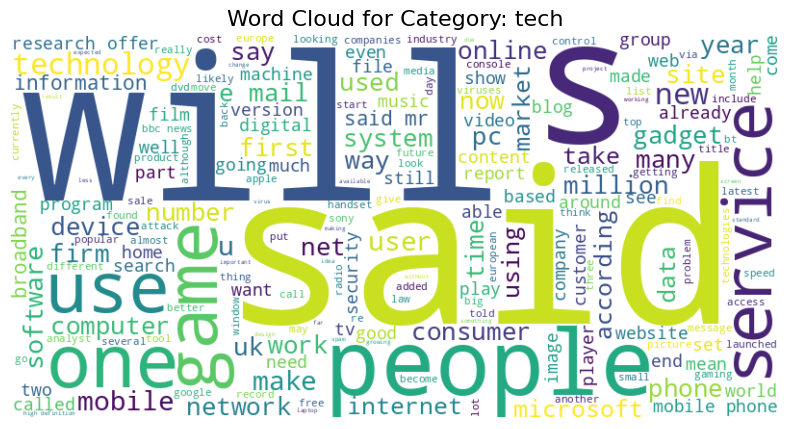

In [9]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df_train is already loaded and contains 'Text' and 'Category' columns

# Group text by category
category_texts = df_train.groupby('Category')['Text'].apply(lambda texts: ' '.join(texts))

# Create a word cloud for each category
for category, text in category_texts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Category: {category}', fontsize=16)
    plt.show()




Common Words: The words "said" and "will" appear prominently across all categories.

Category-Specific:

Business: Words like "market", "company", "share" suggest a focus on corporate activities.

Entertainment: Words such as "film", "music", "show" and "star" highlight topics related to movies, music, and celebrities.

Politics: Words like "blair", "people", "party" indicate discussions around political leaders, elections.

Sport: Terms like "win", "game", "player" emphasize sports events, players and competitions.

Tech: Words such as "use", "people", "new" and "game" reflect discussions on technology, innovations, and software.


In [10]:
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Download necessary resources
nltk.download('stopwords')

# Load English stopwords and initialize stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Define preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize and remove stopwords + stem + remove empty strings
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words and word.strip()]
    
    return ' '.join(words)




[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Apply the function to the 'Text' column
df_train['Cleaned_Text'] = df_train['Text'].apply(preprocess_text)

# Preview the cleaned text
print(df_train[['Text', 'Cleaned_Text']].head())


                                                Text  \
0  worldcom ex-boss launches defence lawyers defe...   
1  german business confidence slides german busin...   
2  bbc poll indicates economic gloom citizens in ...   
3  lifestyle  governs mobile choice  faster  bett...   
4  enron bosses in $168m payout eighteen former e...   

                                        Cleaned_Text  
0  worldcom exboss launch defenc lawyer defend fo...  
1  german busi confid slide german busi confid fe...  
2  bbc poll indic econom gloom citizen major nati...  
3  lifestyl govern mobil choic faster better funk...  
4  enron boss 168m payout eighteen former enron d...  


In [16]:
x= df_train['Cleaned_Text']
y = df_train['Category']

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined